This is an attempt to recreate makemore, following along Andrej Karpathy lecture on YT. :)

1. Loading our dataset into one string and splitting the words at the /n character creating indidividual lines of the names stored in a python list

In [1]:
words = open(r'dataset\names.txt', 'r').read().splitlines()

2. Getting familiar with our dataset, looking the first few examples and the length of the list, as well as the longest and shortest names in the list

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)
min(len(w) for w in words)
max(len(w) for w in words)

15

3. Creating a simple bigram model (Looking at 2 characters, seeing the frequency the characters follow another one, to gather info on predicting the next character based on the character we have)
create an empty dictionary to store our pair of characters along with the count of the pair, #(S) & (E) are special characters to signal the start and end of a string (name) respectively. bigram is a tuple of chars iterated over by the second For loop. Got tired of typing but yeah :) Last code cell sorts the list by descending order of counts.

b = {}
for w in words[0:]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [5]:
sorted(b.items(), key = lambda kv: -kv[1])

NameError: name 'b' is not defined

4. Use PyTorch to efficiently store and manipulate the counts in a 2-D Torch Tensor. Import the torch library to make use of PyTorch, and init a 28x28 tensor with 0 and data type set to 32-bit Integers. Join the names in the dataset into one string use 'set' to get rid of duplicate characters to create a list of possible characters (of the alphabet) sorted. Create a dictionary mapping each character to an Integer, and explicitly append our Special characters to the dictionary.

In [2]:
import torch

In [5]:
N = torch.zeros((27,27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
S_to_i = {s:i+1 for i,s in enumerate(chars)}
S_to_i['.'] = 0
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

5. Basically the bigram above, but implemented in Torch tensor, showing the counts of each bigram as an entry. (Like a table, with the rows and columns as the characters, and each data entry in the column is the count of how many times the row-index & column-index are paired together). Last code cell inverts the mapping of our S_to_I dictionary, and maps the Integer to the String (character) in variable I_to_S.

In [6]:
for w in words[0:]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = S_to_i[ch1]
        ix2 = S_to_i[ch2]
        N[ix1,ix2]+=1

In [7]:
I_to_S = {i:s for s,i in S_to_i.items()}
I_to_S

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

6. Plotting our data, so we can visualize, Edits 4. & 5., replacing the special chars with a dot(.) symbol, allows us to have only 27 possible chars in our set list of chars, and eliminates the plotting of impossible events (highly unlikely), such as the end char being the first char in a string and start char being the end of a string. This means we also modified our array to have dim 27x27, instead of 28x28.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

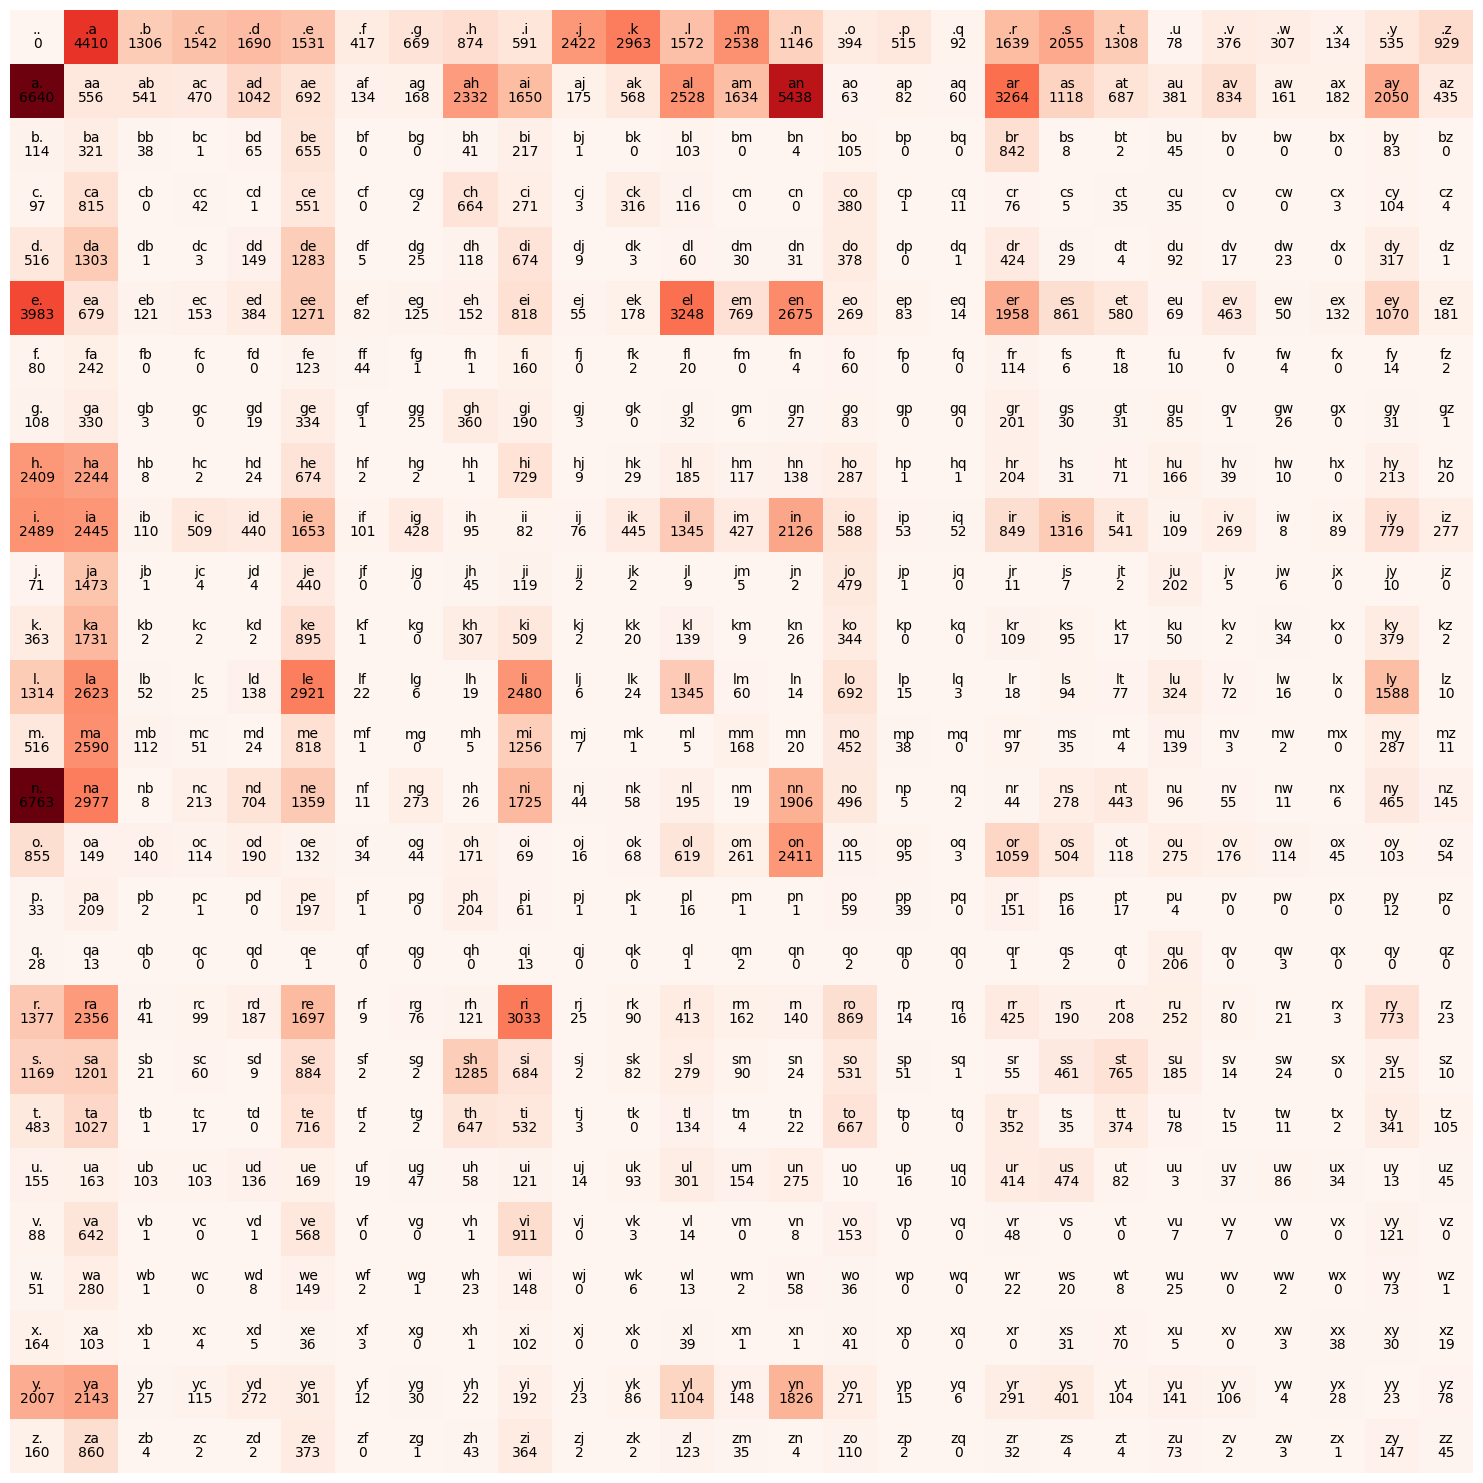

In [14]:
plt.figure(figsize=(19,19))
plt.imshow(N, cmap='Reds')
for i in range (27):
    for j in range(27):
        chstr = I_to_S[i] + I_to_S[j]
        plt.text(j,i,chstr, ha='center', va='bottom', color='black')
        plt.text(j,i, N[i,j].item(), ha='center', va='top', color='black')
plt.axis('off');

7. Sampling from our Tensor array to calculate probability

In [15]:
N[0, :] #can also use N[0] to pluck out the row at index 0 (our starting chars)

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [16]:
#Calculate probability, switch our plucked row to float32 and normalize to 1.
p = N[0].float()
p = p / p.sum()
p


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

For efficiency - Instead of normalizing the probability in the loop, meaning every iteration we have to normalize the probability of the row, we can normalize the probability of the array upfront and pull the probability for a row in the loop. Store this variable in P.

N.B Broadcasting semantics, confirm if the Tensors are broadcastable by checking that the conditions are met. Also Keepdim arg in torch.sum will keep the dimension of the sum (so if summed by columns, keepdim will keep 1 row holding the sum values, and vice versa), otherwise the function will return a vector with the sums in it.

Note: Dim(Rows X Col), keepdim == keepdims & /= in-place operation, again for efficiency! :)

In [17]:
P = (N+1).float()
P /= P.sum(1,keepdims=True)
#P = P / P.sum(1, keepdim=True)
#P.size()

In [18]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix = 0
    out = []
    while True:
        p = P[ix]
       # p = torch.ones(27) / 27.0 Even distribution of likelihood
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        out.append(I_to_S[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [20]:
log_mle = 0.0
n = 0
#for w in words[0:]:
for w in ['andy']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = S_to_i[ch1]
        ix2 = S_to_i[ch2]
        N[ix1,ix2]+=1
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_mle += logprob
        n += 1
        print(f'{ch1, ch2}, {prob:.4f}, {logprob:.4f}, {neg_log_prob:.4f}')
        
print(f'{log_mle=}')
neg_log_mle = -log_mle
print(f'{neg_log_mle=}')
print(f'{neg_log_mle/n}')

NameError: name 'neg_logprob' is not defined

Create a training set of bigrams (x,y)

In [22]:
xs , ys = [] ,[]

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = S_to_i[ch1]
        ix2 = S_to_i[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)



In [10]:
import torch.nn.functional as F

In [23]:
plt.imshow(x_enc)

NameError: name 'x_enc' is not defined

In [ ]:
x_enc.dtype

torch.float32

Feeding the input vector into the neural net using matrix multiplication.

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)
x_enc = F.one_hot(xs, num_classes=27).float()
logits = (x_enc @ W) #log counts, matrix multiplication of encoded inputs X weights resulting in 5X27 matrix
counts = logits.exp() #Fake counts, similar to N but synthetic as W is init random
probs = counts / counts.sum(1,keepdim=True) # Probability for our next character

Last two lines of code above are called a Softmax function. This is somewhat a non-linearity, however this is done as the last operation in our NN. It returns the probability distribution, each element is non-negative, and the sum of the elements is 1. The cell below is basically a summary of everything covered thus far, from MLE up to and including the softmax function above.

In [24]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print('------------------')
    print(f'bigram example {i+1}: {I_to_S[x]}{I_to_S[y]} (indices {x},{y})')
    print(f'Input to the neural network:',x)
    print('Output probabilities from the neural network:', probs[i])
    print('Label (the actual character):', y)
    p = probs[i,y]
    print('Probability assigned by the neural network to the correct character:', p.item())
    logp = torch.log(p)
    print('Log likelihood:', logp.item())
    nll = -logp
    print('Negative log likelihood:', nll.item())
    nlls[i] = nll
    
print('=================')
print('Avg negative log likelihood (LOSS):', nlls.mean().item())

------------------
bigram example 1: .e (indices 0,5)
Input to the neural network: 0


NameError: name 'probs' is not defined

Up Next is --- Optimization ---

In [ ]:
g = torch.Generator()
W = torch.randn((27,27), generator=g, requires_grad=True)

In [ ]:
#Forward Pass
x_enc = F.one_hot(xs, num_classes=27).float()
logits = (x_enc @ W) #log counts, matrix multiplication of encoded inputs X weights resulting in 5X27 matrix
counts = logits.exp() #Fake counts, similar to N but synthetic as W is init random
probs = counts / counts.sum(1,keepdim=True) # Probability for our next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(loss.item())

3.7091126441955566


In [ ]:
#Backward pass
W.grad = None #set gradients 0, when set to None, PyTorch reads the grad as non-existant and fills it in with a 0
loss.backward()

In [ ]:
#Update
W.data += -0.1 * W.grad

Put Everything together

In [13]:
#Create the dataset
xs , ys = [] ,[]

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = S_to_i[ch1]
        ix2 = S_to_i[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num)

#Init the Network
g = torch.Generator()
W = torch.randn((27,27), generator=g, requires_grad=True)

number of examples: 228146


In [18]:
#Gradient descent
for k in range (100):
    #Forward Pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    logits = (x_enc @ W) #log counts, matrix multiplication of encoded inputs X weights resulting in 5X27 matrix
    counts = logits.exp() #Fake counts, similar to N but synthetic as W is init random
    probs = counts / counts.sum(1,keepdim=True) # Probability for our next character
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())
    
    #Backward pass
    W.grad = None #set gradients 0, when set to None, PyTorch reads the grad as non-existant and fills it in with a 0
    loss.backward()
    
    #Update
    W.data += -50 * W.grad

2.4729554653167725
2.4727323055267334
2.4725143909454346
2.4723005294799805
2.47209095954895
2.471886396408081
2.4716858863830566
2.471489429473877
2.471296787261963
2.4711081981658936
2.47092342376709
2.4707424640655518
2.470564842224121
2.470390558242798
2.4702203273773193
2.470053195953369
2.469888687133789
2.4697279930114746
2.4695699214935303
2.4694154262542725
2.4692630767822266
2.469114065170288
2.4689674377441406
2.4688236713409424
2.4686825275421143
2.4685442447662354
2.4684078693389893
2.4682741165161133
2.4681429862976074
2.4680140018463135
2.4678874015808105
2.4677624702453613
2.467639923095703
2.467519521713257
2.4674012660980225
2.467284679412842
2.467170238494873
2.467057943344116
2.466946840286255
2.4668378829956055
2.466730833053589
2.466625452041626
2.4665215015411377
2.4664194583892822
2.4663186073303223
2.466219902038574
2.4661223888397217
2.4660260677337646
2.4659318923950195
2.465838670730591
2.465747356414795
2.4656565189361572
2.4655678272247314
2.46548008918762

Sampling from the model (Testing Purposes) (Sampling 10 words/names)

In [23]:
#Previous Sampling method vs Sampling from the Neural Net
for i in range(10):
    ix = 0
    out = []
    while True:
        #p = P[ix]
        #p = torch.ones(27) / 27.0 Even distribution of likelihood
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = (x_enc @ W) #log counts, matrix multiplication of encoded inputs X weights resulting in 5X27 matrix
        counts = logits.exp() #Fake counts, similar to N but synthetic as W is init random
        probs = counts / counts.sum(1,keepdim=True) # Probability for our next character
       
        ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
        out.append(I_to_S[ix])
        if ix == 0:
            break
    print(''.join(out))
    


on.
baruhastynaysas.
peie.
tenedelornixtg.
fris.
x.
can.
jenilyn.
th.
lahvila.
